In [1]:
from src.plots_generation.analysis_utils import get_gae_embeddings
from src.baselines.embeddings import get_bert_models, VectorizerProcessor
import pandas as pd
from config import BASE_DIR, get_paths_by_domain

DOMAIN = "bible"
paths = get_paths_by_domain("bible")
df_path = paths["data_csv_path"]
df = pd.read_csv(df_path)
vectorizers = get_bert_models(DOMAIN) + ["trigram", "tfidf"]
processor = VectorizerProcessor(
    df, paths["processed_vectorizers_path"], vectorizers
)
processed_vectorizers = processor.load_or_generate_embeddings()

bert_model = "dicta-il/BEREL"
model_file = "trained_gae_model_bible_BEREL.pth"
param_dict = {
    "num_adjs": 2,
    "epochs": 50,
    "hidden_dim": 300,
    "distance": "cosine",
    "learning_rate": 0.0001,
    "threshold": 0.99,
    "adjacencies": [
        {"type": "tfidf", "params": {"max_features": 10000, "min_df": 0.01}},
        {
            "type": "trigram",
            "params": {
                "analyzer": "char",
                "ngram_range": (3, 3),
                "min_df": 0.01,
                "max_features": 10000,
            },
        },
    ],
}

gae_embeddings = get_gae_embeddings(
    df, processed_vectorizers, bert_model, model_file, param_dict
)

Loaded the embeddings: ['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'dicta-il/MsBERT', 'tfidf', 'trigram']
Loaded the following embeddings dict_keys(['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'dicta-il/MsBERT', 'tfidf', 'trigram'])


/Users/yonatanlou/dev/QumranNLP/src/gnn/adjacency.py:170: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


2025-01-12 15:10:16.155643 - tfidf n edges before filtering: 21146477, n edges after filtering: 219961
2025-01-12 15:10:20.255101 - trigram n edges before filtering: 21987580, n edges after filtering: 219962


In [9]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.metrics.pairwise import cosine_similarity

def remove_outliers(df,gae_embeddings, outlier_threshold = 2):
    
    # Ensure groupby_col is defined
    groupby_col = "book"  # Adjust to match the appropriate column name
    unique_books = df.dropna(subset=["book"], axis=0)[groupby_col].unique()
    
    new_embeddings = []
    new_df = pd.DataFrame()
    
    for book in unique_books:
        # Get the embeddings for the current book
        book_mask = df["book"] == book
        book_indices = np.where(book_mask)[0]
        book_embeddings = gae_embeddings[book_indices]
    
        # Compute the initial average embedding
        avg_embedding = np.mean(book_embeddings, axis=0, keepdims=True)
    
        # Calculate cosine similarities of each embedding to the average
        similarities = cosine_similarity(book_embeddings, avg_embedding).flatten()
    
        # Compute Z-scores for the cosine similarities
        similarity_z_scores = zscore(similarities)
    
        # Filter out embeddings with Z-scores above the threshold
        valid_indices = np.abs(similarity_z_scores) <= outlier_threshold
        valid_embeddings = book_embeddings[valid_indices]
    
        # Append valid embeddings to the list
        new_embeddings.extend(valid_embeddings)
    
        # Append valid rows to new_df
        valid_df_rows = df.loc[book_mask].iloc[valid_indices]
        new_df = pd.concat([new_df, valid_df_rows], ignore_index=True)
    
        print(
            "Removed",
            book_indices.shape[0] - valid_embeddings.shape[0],
            "outliers out of",
            book_indices.shape[0],
        )
    
    # Convert the new embeddings list to a numpy array for consistency
    new_gae_embeddings = np.array(new_embeddings)
    return new_df, new_gae_embeddings



In [ ]:
new_df, new_gae_embeddings = remove_outliers(df,gae_embeddings, outlier_threshold = 2)

In [10]:
import umap
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.manifold import TSNE

def plot_embeddings_projection(embeddings, df, method='umap', random_state=42, save_path=None):
    """
    Create an interactive visualization of embeddings using either UMAP or t-SNE.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        The embedding vectors
    df : pandas.DataFrame
        DataFrame containing a 'book' column
    method : str
        Dimensionality reduction method ('umap' or 'tsne')
    random_state : int
        Random seed for reproducibility
    save_path : str, optional
        If provided, saves the plot to this path as an HTML file
    
    Returns:
    --------
    plotly.graph_objects.Figure
        Interactive Plotly figure
    """
    # Parameters for dimensionality reduction
    n_components = 2
    
    # Choose and apply dimensionality reduction method
    if method.lower() == 'umap':
        reducer = umap.UMAP(
            random_state=random_state,
            n_neighbors=15,
            min_dist=0.1,
            n_components=n_components,
            metric="cosine"
        )
        reduced_embeddings = reducer.fit_transform(embeddings)
        method_name = 'UMAP'
    
    elif method.lower() == 'tsne':
        reducer = TSNE(
            n_components=n_components,
            random_state=random_state,
            init='pca',  # Initialize with PCA for better results
            learning_rate='auto',
            perplexity=30,
            metric='cosine'
        )
        reduced_embeddings = reducer.fit_transform(embeddings)
        method_name = 't-SNE'
    
    else:
        raise ValueError("Method must be either 'umap' or 'tsne'")
    
    # Create a DataFrame with the reduced coordinates and book labels
    plot_df = pd.DataFrame({
        'Dim1': reduced_embeddings[:, 0],
        'Dim2': reduced_embeddings[:, 1],
        'Book': df['book'],
        'Text': df['text']  # Including text for hover information
    })
    
    # Create the interactive plot
    fig = px.scatter(
        plot_df,
        x='Dim1',
        y='Dim2',
        color='Book',
        color_discrete_sequence=px.colors.qualitative.Set3,
        hover_data={
            'Dim1': False,  # Hide Dim1 in hover tooltip
            'Dim2': False,  # Hide Dim2 in hover tooltip
            'Text': False,   # Show text in hover tooltip
            'Book': True    # Show book in hover tooltip
        },
        title=f'{method_name} Visualization of Book Embeddings'
    )
    
    # Update layout for better visualization
    fig.update_layout(
        width=1000,
        height=800,
        title={
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 20}
        },
        legend={
            'title': 'Books',
            'yanchor': 'top',
            'y': 0.99,
            'xanchor': 'left',
            'x': 1.02,
            'bgcolor': 'rgba(255, 255, 255, 0.8)'
        },
        xaxis_title=f'{method_name} Dimension 1',
        yaxis_title=f'{method_name} Dimension 2',
        hovermode='closest'
    )
    
    # Update traces
    fig.update_traces(
        marker=dict(size=6),
        opacity=0.7
    )
    
    # Save to HTML if path is provided
    if save_path:
        fig.write_html(save_path)
    
    return fig








In [ ]:

fig = plot_embeddings_projection(new_gae_embeddings, new_df, method='tsne', random_state=42)
fig.write_html("/Users/yonatanlou/dev/QumranNLP/reports/plots/bible/bible_scatter_plot.html")
fig.show()


In [ ]:

fig = plot_embeddings_projection(new_gae_embeddings, new_df, method='tsne', random_state=42)
fig.write_html("/Users/yonatanlou/dev/QumranNLP/reports/plots/bible/bible_scatter_plot.html")
fig.show()


/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



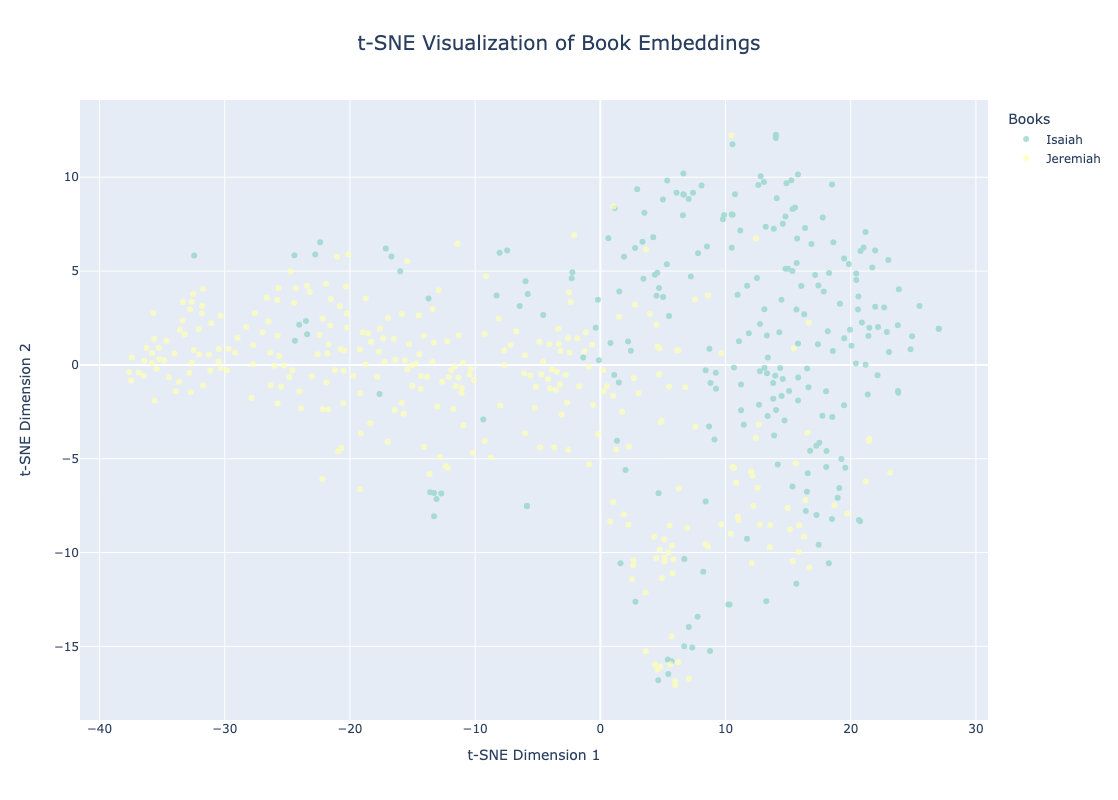

In [59]:
books_to_plot = ["Jeremiah", 'Isaiah']
# books_to_plot = ['2_Samuel', 'Daniel', 'Deuteronomy', 'Esther', 'Exodus', 'Ezra', 'Isaiah', 'Jeremiah', 'Job', 'Jonah', 'Joshua', 'Proverbs', 'Psalms', 'Song_of_songs']

idxs = new_df[new_df["book"].isin(books_to_plot)].index


fig = plot_embeddings_projection(new_gae_embeddings[idxs], new_df.loc[idxs], "tsne")
fig.show()  # This will open the interactive plot in your browser

## Dss

In [49]:
from src.plots_generation.analysis_utils import get_gae_embeddings
from src.baselines.embeddings import get_bert_models, VectorizerProcessor
import pandas as pd
from config import BASE_DIR, get_paths_by_domain

DOMAIN = "dss"
paths = get_paths_by_domain(DOMAIN)
df_path = paths["data_csv_path"]
df = pd.read_csv(df_path)
vectorizers = get_bert_models(DOMAIN) + ["trigram", "tfidf"]
processor = VectorizerProcessor(
    df, paths["processed_vectorizers_path"], vectorizers
)
processed_vectorizers = processor.load_or_generate_embeddings()

bert_model = "dicta-il/BEREL"
# model_file = "trained_gae_model_BEREL-finetuned-DSS-maskedLM.pth"
model_file = "trained_gae_model_BEREL.pth"
param_dict = {
    "num_adjs": 2,
    "epochs": 50,
    "hidden_dim": 300,
    "distance": "cosine",
    "learning_rate": 0.001,
    "threshold": 0.98,
    "adjacencies": [
        {"type": "tfidf", "params": {"max_features": 10000, "min_df": 0.01}},
        {
            "type": "trigram",
            "params": {
                "analyzer": "char",
                "ngram_range": (3, 3),
                "min_df": 0.1,
                "max_features": 7500,
            },
        },
    ],
}
df_no_nulls = df
df_no_nulls["section"] = df_no_nulls["section"].fillna("unknown")
df_no_nulls = df_no_nulls[
    ~(df_no_nulls["composition"].isin(["4QH", "4QM", "4QS", "4QD"]))
]

gae_embeddings = get_gae_embeddings(
    df_no_nulls, processed_vectorizers, bert_model, model_file, param_dict
)

Loaded the embeddings: ['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'yonatanlou/BEREL-finetuned-DSS-maskedLM', 'tfidf', 'trigram', 'starr', 'yonatanlou/alephbert-base-finetuned-DSS-maskedLM', 'yonatanlou/dictabert-finetuned-DSS-maskedLM', 'dicta-il/MsBERT']
Loaded the following embeddings dict_keys(['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'yonatanlou/BEREL-finetuned-DSS-maskedLM', 'tfidf', 'trigram', 'starr', 'yonatanlou/alephbert-base-finetuned-DSS-maskedLM', 'yonatanlou/dictabert-finetuned-DSS-maskedLM', 'dicta-il/MsBERT'])
2025-01-20 19:30:32.086817 - tfidf n edges before filtering: 766699, n edges after filtering: 17261
2025-01-20 19:30:32.670443 - trigram n edges before filtering: 863041, n edges after filtering: 17261


In [50]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.metrics.pairwise import cosine_similarity

def remove_outliers(df,gae_embeddings, outlier_threshold = 2):
    
    # Ensure groupby_col is defined
    groupby_col = "composition"  # Adjust to match the appropriate column name
    unique_books = df.dropna(subset=[groupby_col], axis=0)[groupby_col].unique()
    
    new_embeddings = []
    new_df = pd.DataFrame()
    
    for book in unique_books:
        # Get the embeddings for the current book
        book_mask = df[groupby_col] == book
        book_indices = np.where(book_mask)[0]
        book_embeddings = gae_embeddings[book_indices]
    
        # Compute the initial average embedding
        avg_embedding = np.mean(book_embeddings, axis=0, keepdims=True)
    
        # Calculate cosine similarities of each embedding to the average
        similarities = cosine_similarity(book_embeddings, avg_embedding).flatten()
    
        # Compute Z-scores for the cosine similarities
        similarity_z_scores = zscore(similarities)
    
        # Filter out embeddings with Z-scores above the threshold
        valid_indices = np.abs(similarity_z_scores) <= outlier_threshold
        valid_embeddings = book_embeddings[valid_indices]
    
        # Append valid embeddings to the list
        new_embeddings.extend(valid_embeddings)
    
        # Append valid rows to new_df
        valid_df_rows = df.loc[book_mask].iloc[valid_indices]
        new_df = pd.concat([new_df, valid_df_rows], ignore_index=True)
    
        print(
            "Removed",
            book_indices.shape[0] - valid_embeddings.shape[0],
            "outliers out of",
            book_indices.shape[0],
        )
    
    # Convert the new embeddings list to a numpy array for consistency
    new_gae_embeddings = np.array(new_embeddings)
    return new_df, new_gae_embeddings



In [51]:
new_df, new_gae_embeddings = remove_outliers(df_no_nulls,gae_embeddings, outlier_threshold = 2.5)


Removed 3 outliers out of 46
Removed 1 outliers out of 42
Removed 0 outliers out of 7
Removed 0 outliers out of 6
Removed 3 outliers out of 45
Removed 3 outliers out of 49
Removed 3 outliers out of 82
Removed 0 outliers out of 6
Removed 1 outliers out of 10
Removed 2 outliers out of 85
Removed 1 outliers out of 13
Removed 0 outliers out of 7
Removed 0 outliers out of 4
Removed 2 outliers out of 50
Removed 0 outliers out of 3
Removed 1 outliers out of 43
Removed 0 outliers out of 11
Removed 0 outliers out of 14
Removed 0 outliers out of 9
Removed 0 outliers out of 10
Removed 0 outliers out of 5
Removed 1 outliers out of 17
Removed 1 outliers out of 39
Removed 2 outliers out of 61
Removed 0 outliers out of 4
Removed 0 outliers out of 4
Removed 0 outliers out of 15
Removed 2 outliers out of 19
Removed 1 outliers out of 13
Removed 1 outliers out of 15
Removed 0 outliers out of 18
Removed 0 outliers out of 11
Removed 0 outliers out of 5
Removed 2 outliers out of 132
Removed 0 outliers out o

In [52]:
import umap
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.manifold import TSNE

def plot_embeddings_projection(embeddings, df, method='umap', random_state=42, save_path=None):
    """
    Create an interactive visualization of embeddings using either UMAP or t-SNE.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        The embedding vectors
    df : pandas.DataFrame
        DataFrame containing a 'book' column
    method : str
        Dimensionality reduction method ('umap' or 'tsne')
    random_state : int
        Random seed for reproducibility
    save_path : str, optional
        If provided, saves the plot to this path as an HTML file
    
    Returns:
    --------
    plotly.graph_objects.Figure
        Interactive Plotly figure
    """
    # Parameters for dimensionality reduction
    n_components = 2
    
    # Choose and apply dimensionality reduction method
    if method.lower() == 'umap':
        reducer = umap.UMAP(
            random_state=random_state,
            n_neighbors=15,
            min_dist=0.1,
            n_components=n_components,
            metric="cosine"
        )
        reduced_embeddings = reducer.fit_transform(embeddings)
        method_name = 'UMAP'
    
    elif method.lower() == 'tsne':
        reducer = TSNE(
            n_components=n_components,
            random_state=random_state,
            init='pca',  # Initialize with PCA for better results
            learning_rate='auto',
            perplexity=30,
            metric='cosine'
        )
        reduced_embeddings = reducer.fit_transform(embeddings)
        method_name = 't-SNE'
    
    else:
        raise ValueError("Method must be either 'umap' or 'tsne'")
    
    # Create a DataFrame with the reduced coordinates and book labels
    plot_df = pd.DataFrame({
        'Dim1': reduced_embeddings[:, 0],
        'Dim2': reduced_embeddings[:, 1],
        'Composition': df['composition'],
        'Text': df['text']  # Including text for hover information
    })
    
    # Create the interactive plot
    fig = px.scatter(
        plot_df,
        x='Dim1',
        y='Dim2',
        color='Composition',
        color_discrete_sequence=px.colors.qualitative.Set3,
        hover_data={
            'Dim1': False,  # Hide Dim1 in hover tooltip
            'Dim2': False,  # Hide Dim2 in hover tooltip
            'Text': False,   # Show text in hover tooltip
            'Composition': True    # Show book in hover tooltip
        },
        title=f'{method_name} Visualization of Composition Embeddings'
    )
    
    # Update layout for better visualization
    fig.update_layout(
        width=1000,
        height=800,
        title={
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 20}
        },
        legend={
            'title': 'Books',
            'yanchor': 'top',
            'y': 0.99,
            'xanchor': 'left',
            'x': 1.02,
            'bgcolor': 'rgba(255, 255, 255, 0.8)'
        },
        xaxis_title=f'{method_name} Dimension 1',
        yaxis_title=f'{method_name} Dimension 2',
        hovermode='closest'
    )
    
    # Update traces
    fig.update_traces(
        marker=dict(size=6),
        opacity=0.7
    )
    
    # Save to HTML if path is provided
    if save_path:
        fig.write_html(save_path)
    
    return fig








/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



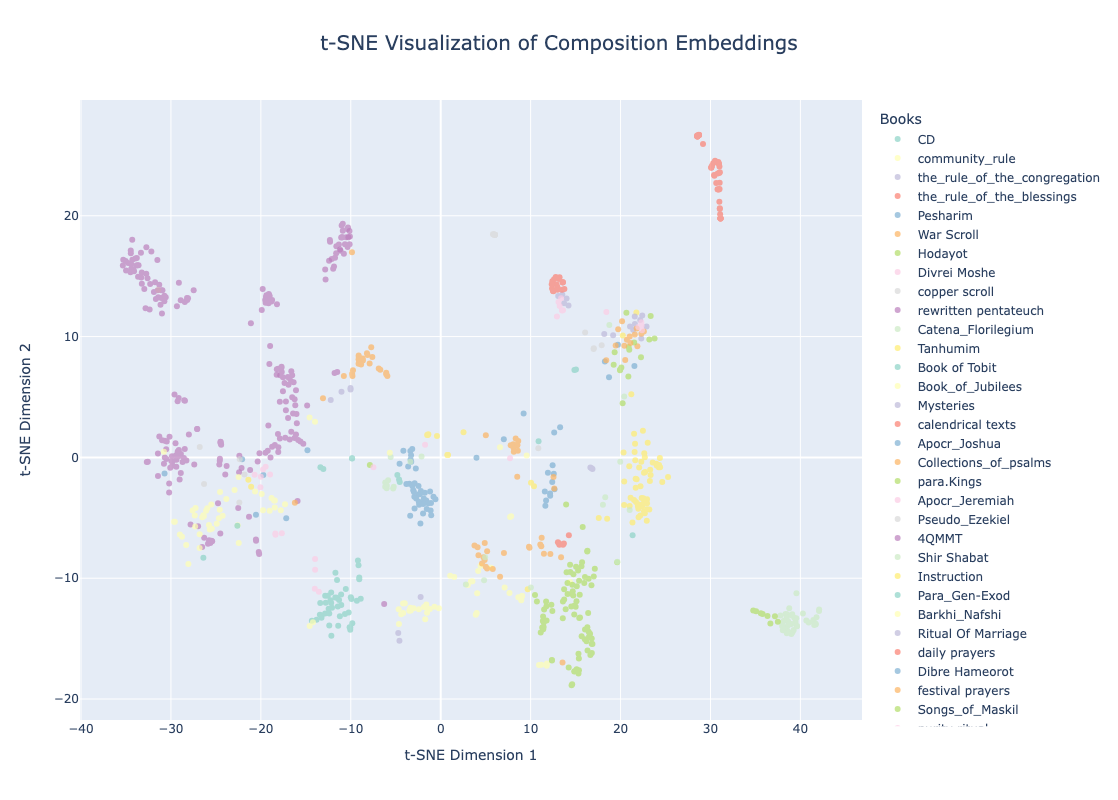

In [53]:
fig = plot_embeddings_projection(new_gae_embeddings, new_df, method='tsne', random_state=42)
# fig.write_html("/Users/yonatanlou/dev/QumranNLP/reports/plots/bible/bible_scatter_plot.html")
fig.show()

In [43]:
df[df["section"].isna()]["composition"].unique()

array([], dtype=object)